In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

In [2]:
!ls | grep .csv

predict.csv
training.csv


In [3]:
train_df = pd.read_csv('training.csv')
train_orig_df = train_df.copy()
pred_df = pd.read_csv('predict.csv')

In [4]:
train_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,...,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank
0,175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,other,57727,space,0.99973,1,...,3089,viewed,male,0,0,1,other,1,0.23077,0.73677
1,175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,forum,111913,space,0.99977,0,...,44661,viewed,male,0,0,1,other,1,0.23077,0.78240
2,175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,forum,111913,space,0.99977,0,...,3080,viewed,male,0,0,1,marketing,1,0.23077,0.82125
3,175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,other,9037,space,0.99949,0,...,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522
4,175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,other,9037,space,0.99949,0,...,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9418 entries, 0 to 9417
Data columns (total 72 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              9418 non-null   int64  
 1   posted_time                     9418 non-null   float64
 2   updated_time                    9418 non-null   float64
 3   age                             9418 non-null   float64
 4   updated_age                     9418 non-null   float64
 5   app_type                        9418 non-null   object 
 6   owner_id                        9418 non-null   int64  
 7   owner_type                      9418 non-null   object 
 8   owner_influence                 9418 non-null   float64
 9   number_of_likes                 9418 non-null   int64  
 10  number_of_comments              9418 non-null   int64  
 11  reactivity                      9418 non-null   float64
 12  is_mentions_me                  94

No 'Null' values. 

In [6]:
all_cols = [col for col in train_df.columns if col != 'rank']
num_cols = [col for col in all_cols if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in all_cols if col not in num_cols]

print("Amount of number columns: {}".format(len(num_cols)))
print("Amount of categorical columns: {}".format(len(cat_cols)))

Amount of number columns: 52
Amount of categorical columns: 19


In [7]:
train_df[cat_cols].nunique()

app_type               6
owner_type             2
poster_gender          2
poster_focus           5
participant1_action    3
participant1_gender    2
participant1_focus     4
participant2_action    3
participant2_gender    2
participant2_focus     4
participant3_action    3
participant3_gender    2
participant3_focus     4
participant4_action    3
participant4_gender    2
participant4_focus     4
participant5_action    3
participant5_gender    2
participant5_focus     4
dtype: int64

We have a few different values in each column, so there is no need to create some complex embedding system.

Let's take a closer look on this values.

In [8]:
print("Unique values in every categorical column:", end="\n\n")
for col in cat_cols:
    print("{:19s} --> {}".format(col, train_df[col].unique()))

Unique values in every categorical column:

app_type            --> ['other' 'forum' 'wiki' 'calendar' 'poll' 'social']
owner_type          --> ['space' 'user']
poster_gender       --> ['male' 'female']
poster_focus        --> ['marketing' 'other' 'engineering' 'sales' 'none']
participant1_action --> ['liked' 'commented' 'viewed']
participant1_gender --> ['male' 'female']
participant1_focus  --> ['marketing' 'other' 'engineering' 'sales']
participant2_action --> ['viewed' 'commented' 'liked']
participant2_gender --> ['male' 'female']
participant2_focus  --> ['other' 'marketing' 'sales' 'engineering']
participant3_action --> ['viewed' 'commented' 'liked']
participant3_gender --> ['male' 'female']
participant3_focus  --> ['marketing' 'other' 'engineering' 'sales']
participant4_action --> ['viewed' 'liked' 'commented']
participant4_gender --> ['male' 'female']
participant4_focus  --> ['other' 'marketing' 'sales' 'engineering']
participant5_action --> ['viewed' 'liked' 'commented']
partici

### Plotting and exploring data

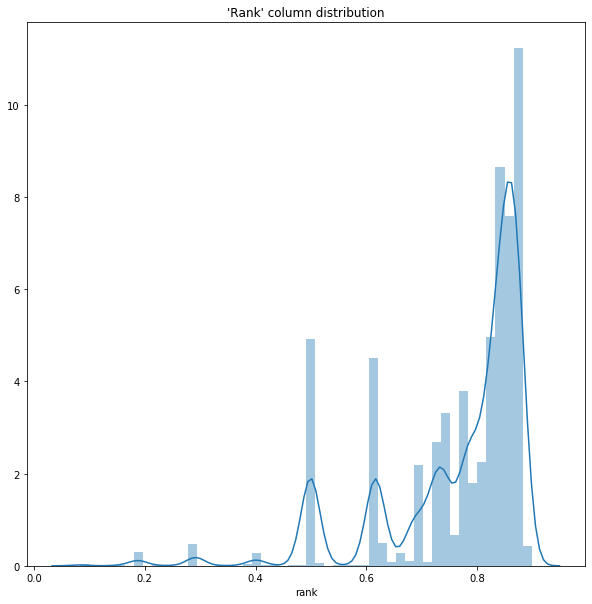

In [9]:
# Looking at label column.

plt.figure(figsize=(10, 10))
plt.title("'Rank' column distribution")

sns.distplot(train_df['rank'])

Not normal.

Also, some anomalies at 0.5 and 0.6 values.

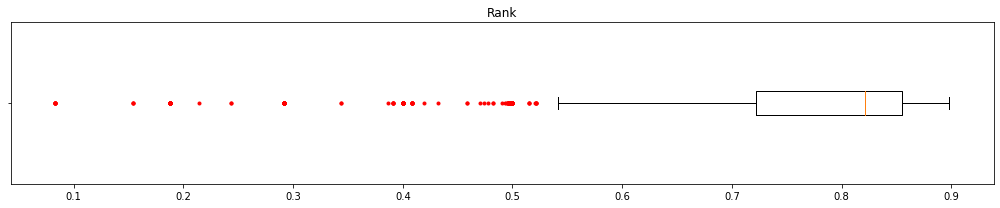

In [10]:
plt.figure(figsize=(14, 3))
plt.boxplot(x=train_df['rank'], vert=False, sym="r.")
plt.tick_params(labelleft=False)
plt.title('Rank')

plt.tight_layout()

Many outliers, but values are not 'impossible' to get.

In [11]:
# Get rid of redundant columns
redundant_cols = ['poster_is_employee', 'poster_is_lead', 'poster_order',
                  'participant1_is_employee', 'participant1_is_lead', 'participant1_order',
                  'participant2_is_employee', 'participant2_is_lead', 'participant2_order',
                  'participant3_is_employee', 'participant3_is_lead', 'participant3_order',
                  'participant4_is_employee', 'participant4_is_lead', 'participant4_order',
                  'participant5_is_employee', 'participant5_is_lead', 'participant5_order',
                  'id', 'participant1_id', 'participant2_id', 'participant3_id',
                  'participant4_id', 'participant5_id', 'owner_id', 'poster_id',
                  'posted_time', 'updated_time', 'age', 'updated_age']
useful_cols = [i for i in all_cols if i not in redundant_cols]

train_df = train_df[useful_cols]

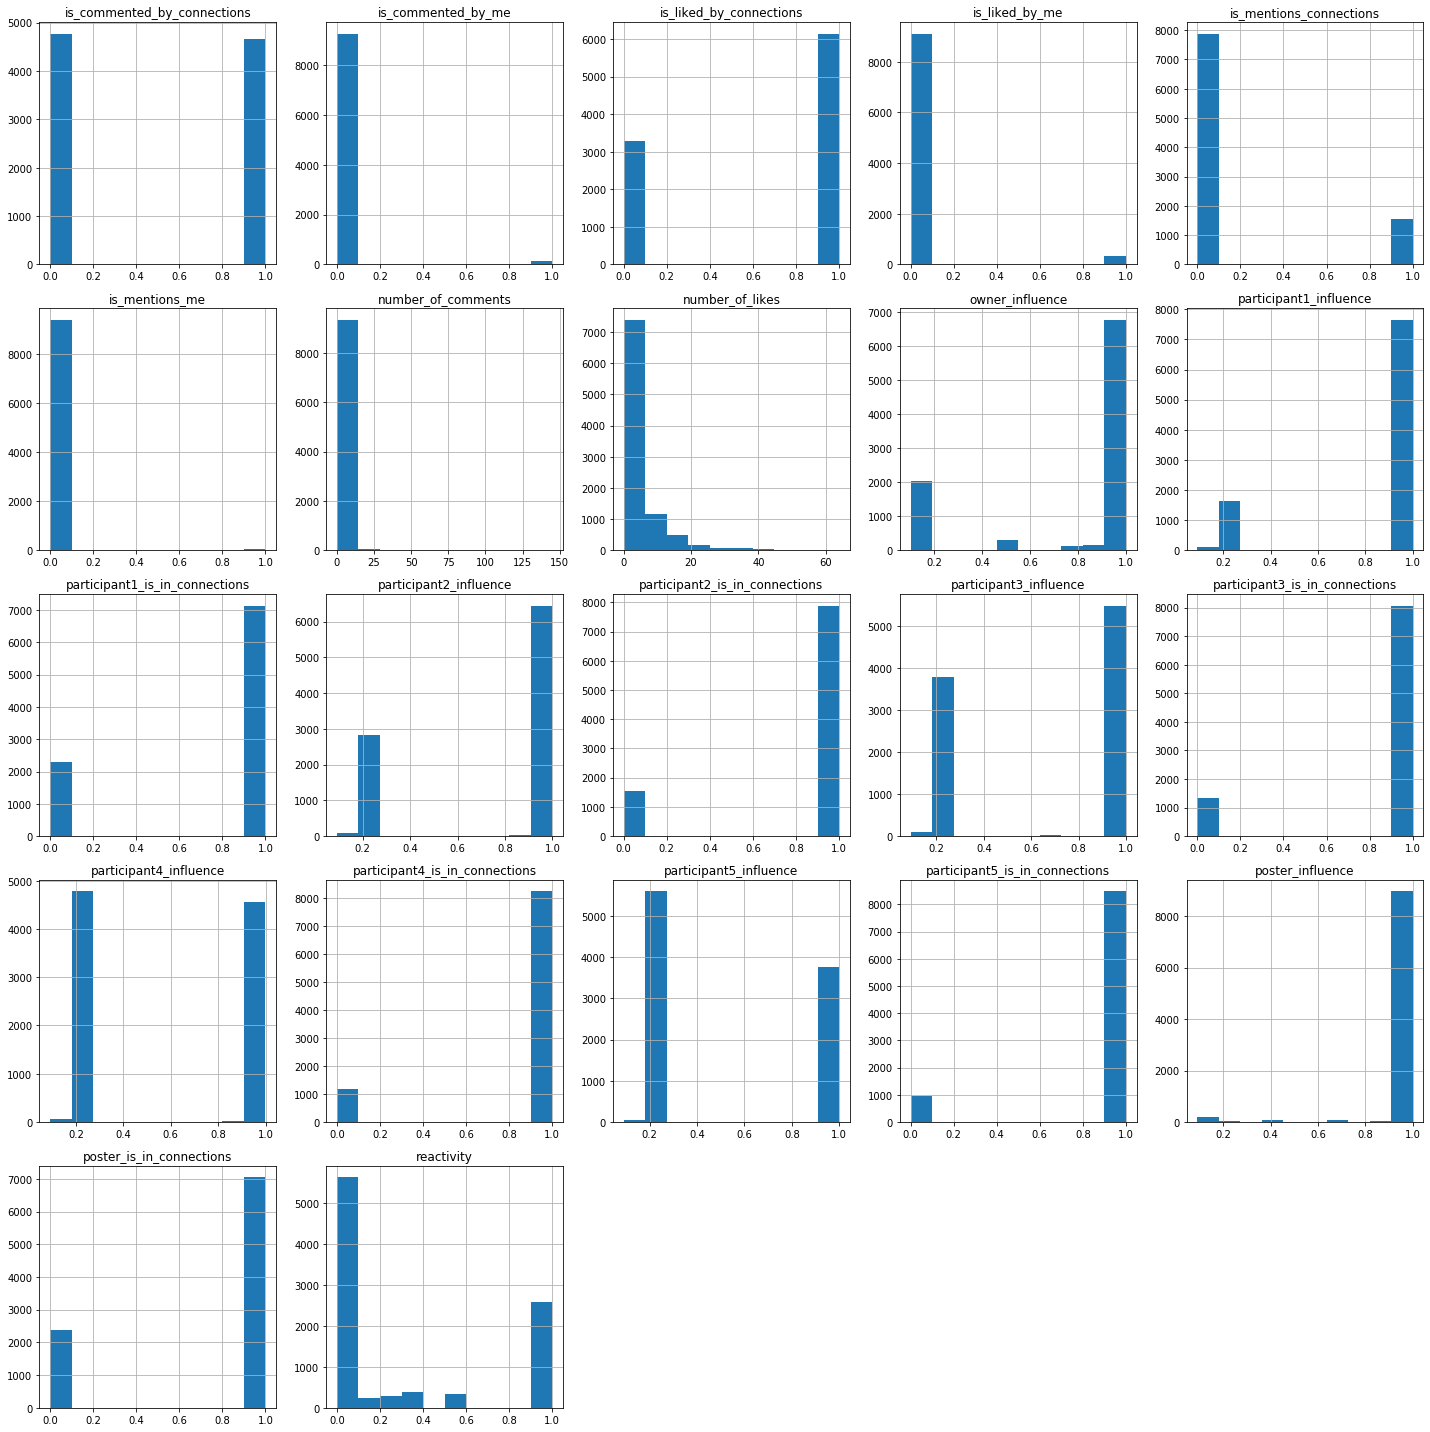

In [12]:
hist = train_df.hist(figsize=(20, 20))

plt.tight_layout()

In [13]:
# sns.pairplot(data=train_df, hue='poster_focus', diag_kws={'bw': 1.5})

#### Data Relationships

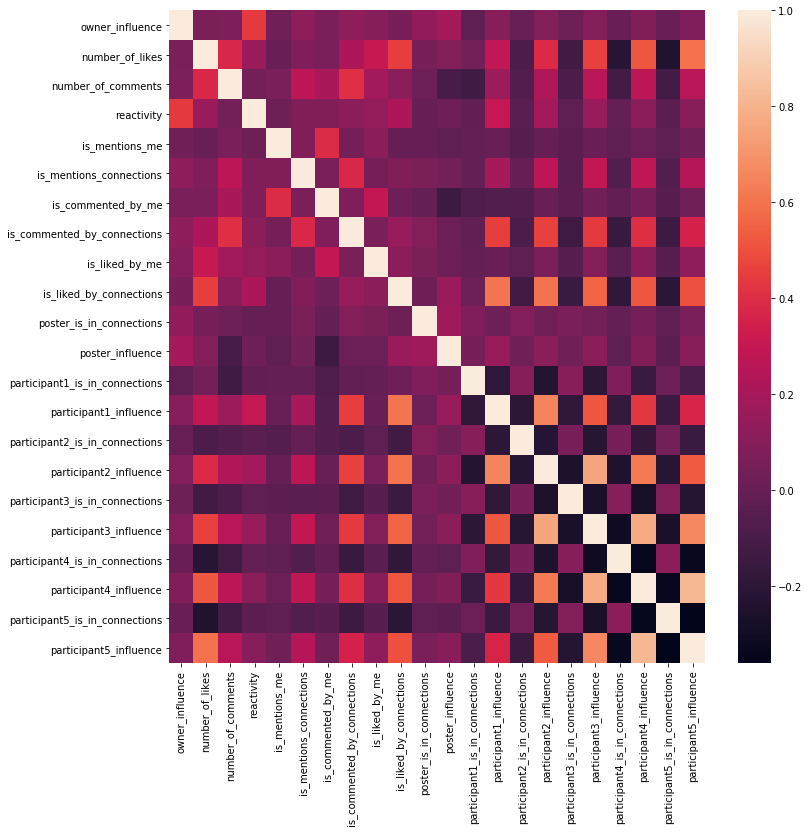

In [14]:
corr_df = train_df.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_df, annot=False)

### Preprocessing

We have a problem regarding using Kmeans algorithm with our data. 

Such algorithm can't work with categorical data. Also I will try to use One Hot Encoding, but it also brings us some problem, especially with 'distances' between different categories.

In [15]:
from sklearn.preprocessing import OneHotEncoder

In [16]:
all_cols = [col for col in train_df.columns] # if col != 'rank']
num_cols = [col for col in all_cols if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in all_cols if col not in num_cols]

print("Amount of number columns: {}".format(len(num_cols)))
print("Amount of categorical columns: {}".format(len(cat_cols)))

Amount of number columns: 22
Amount of categorical columns: 19


In [17]:
train_df.head()

,app_type,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,...,participant4_action,participant4_gender,participant4_is_in_connections,participant4_focus,participant4_influence,participant5_action,participant5_gender,participant5_is_in_connections,participant5_focus,participant5_influence
0,other,space,0.99973,1,0,1.00000,0,0,0,0,...,viewed,male,1,other,0.23077,viewed,male,1,other,0.23077
1,forum,space,0.99977,0,2,0.12336,0,0,0,1,...,viewed,male,1,marketing,0.23077,viewed,male,1,other,0.23077
2,forum,space,0.99977,0,3,0.12336,0,0,0,1,...,viewed,male,1,other,0.23077,viewed,male,1,marketing,0.23077
3,other,space,0.99949,0,0,0.00000,0,0,0,0,...,viewed,male,1,other,0.23077,viewed,male,1,marketing,0.23077
4,other,space,0.99949,0,0,0.00000,0,0,0,0,...,viewed,male,1,other,0.23077,viewed,male,1,marketing,0.23077


In [18]:
encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(train_df[cat_cols].to_numpy())
rez = encoder.transform(train_df[cat_cols].to_numpy())
rez_df = pd.DataFrame(rez.toarray())
    
rez_df.index = train_df.index

new_feature_names = encoder.get_feature_names(cat_cols)
rename_to_new = {old: new for old, new in zip(list(range(len(new_feature_names))), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

rez_df.head()

,app_type_calendar,app_type_forum,app_type_other,app_type_poll,app_type_social,app_type_wiki,owner_type_space,owner_type_user,poster_gender_female,poster_gender_male,...,participant4_focus_sales,participant5_action_commented,participant5_action_liked,participant5_action_viewed,participant5_gender_female,participant5_gender_male,participant5_focus_engineering,participant5_focus_marketing,participant5_focus_other,participant5_focus_sales
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [19]:
train_enc_df = train_df.copy()
train_enc_df = train_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
train_enc_df = train_enc_df.drop(cat_cols, axis=1)

train_enc_df.head()

,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,...,participant4_focus_sales,participant5_action_commented,participant5_action_liked,participant5_action_viewed,participant5_gender_female,participant5_gender_male,participant5_focus_engineering,participant5_focus_marketing,participant5_focus_other,participant5_focus_sales
0,0.99973,1,0,1.00000,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.99977,0,2,0.12336,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.99977,0,3,0.12336,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.99949,0,0,0.00000,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.99949,0,0,0.00000,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


### Clustering

In [20]:
from sklearn.cluster import KMeans

In [21]:
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(train_enc_df)
    inertia.append(np.sqrt(kmeans.inertia_))

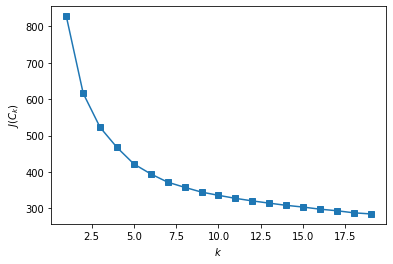

In [22]:
plt.plot(range(1, 20), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Lets take a K = 6 as a possible elbow point.

In [23]:
kmeans = KMeans(n_clusters=6, random_state=1).fit(train_enc_df)
result = kmeans.labels_
print(len(result))

9418


In [24]:
final_df = train_df.copy()
final_df['cluster'] = result
final_df['rank'] = train_orig_df['rank']

final_enc_df = train_enc_df.copy()
final_enc_df['cluster'] = result
final_enc_df['rank'] = train_orig_df['rank']

final_df.head()

,app_type,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,...,participant4_is_in_connections,participant4_focus,participant4_influence,participant5_action,participant5_gender,participant5_is_in_connections,participant5_focus,participant5_influence,cluster,rank
0,other,space,0.99973,1,0,1.00000,0,0,0,0,...,1,other,0.23077,viewed,male,1,other,0.23077,0,0.73677
1,forum,space,0.99977,0,2,0.12336,0,0,0,1,...,1,marketing,0.23077,viewed,male,1,other,0.23077,0,0.78240
2,forum,space,0.99977,0,3,0.12336,0,0,0,1,...,1,other,0.23077,viewed,male,1,marketing,0.23077,3,0.82125
3,other,space,0.99949,0,0,0.00000,0,0,0,0,...,1,other,0.23077,viewed,male,1,marketing,0.23077,0,0.61522
4,other,space,0.99949,0,0,0.00000,0,0,0,0,...,1,other,0.23077,viewed,male,1,marketing,0.23077,0,0.61522


In [25]:
final_df[final_df['cluster'] == 4]

,app_type,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,...,participant4_is_in_connections,participant4_focus,participant4_influence,participant5_action,participant5_gender,participant5_is_in_connections,participant5_focus,participant5_influence,cluster,rank
7703,other,space,0.1,8,114,0.0,0,1,1,1,...,1,marketing,0.99866,commented,male,0,marketing,0.09091,4,0.81850
7775,other,space,0.1,17,136,0.0,0,1,1,1,...,1,marketing,0.23077,commented,male,1,other,0.23077,4,0.79507
8522,other,space,0.1,4,105,0.0,0,1,1,1,...,0,other,0.09091,commented,male,0,sales,0.09091,4,0.64097
9328,other,space,0.1,7,145,0.0,0,1,0,1,...,0,other,0.09091,commented,male,0,other,0.09091,4,0.62199


### Visualization

In [26]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import animation
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [27]:
def prepare_pca(n_components, data, kmeans_labels):
    """Function for preparing PCA dataframe."""
    
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df = pd.DataFrame(matrix)
    df.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df['labels'] = kmeans_labels
    
    return df

def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N = 360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

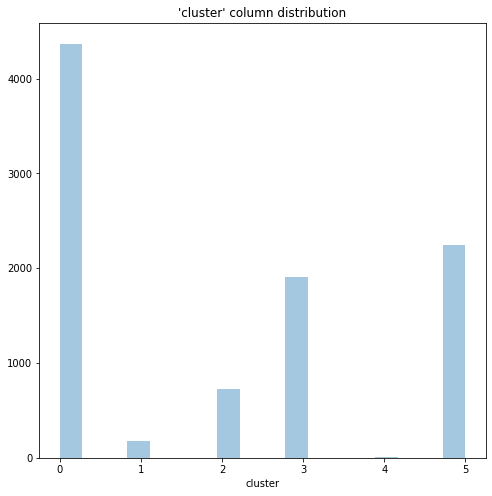

In [28]:
# Looking at cluster column.

plt.figure(figsize=(8, 8))
plt.title("'cluster' column distribution")

sns.distplot(final_df['cluster'], kde=False)

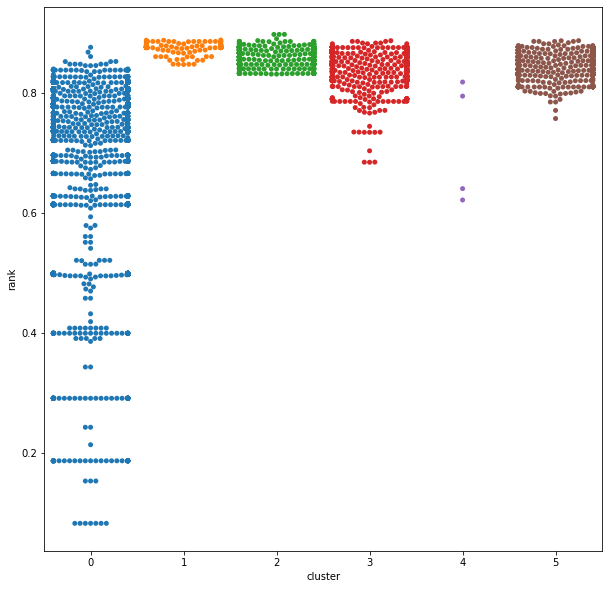

In [29]:
plt.figure(figsize=(10, 10))
sns.swarmplot(x='cluster', y='rank', data=final_df)

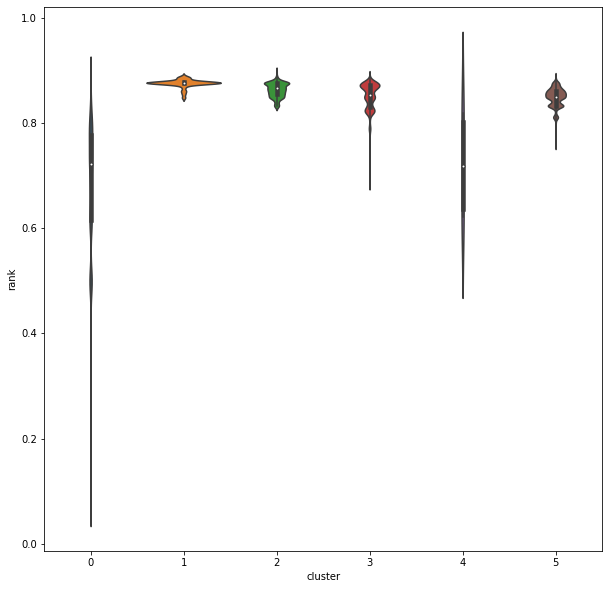

In [30]:
plt.figure(figsize=(10, 10))
sns.violinplot(x='cluster', y='rank', data=final_df)

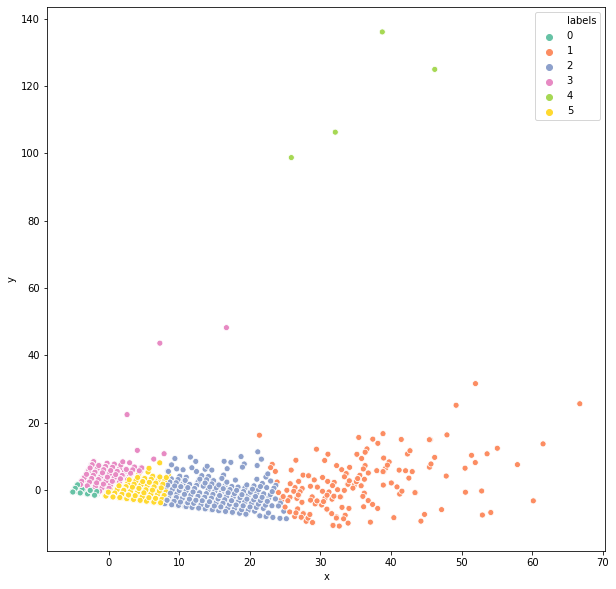

In [31]:
# Seeing PCA of the resulting clustering

pca_df = prepare_pca(2, final_enc_df, kmeans.labels_)
plt.figure(figsize=(10, 10))
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, palette="Set2")

In [32]:
tsne_3d_df = prepare_tsne(3, final_enc_df, kmeans.labels_)

In [33]:
tsne_3d_df.head()

,x,y,z,labels
0,-5.759779,9.491225,20.195257,0
1,-0.701393,-26.236366,10.587480,0
2,1.396381,-26.219955,-2.827281,3
3,-16.889608,-3.535193,17.219234,0
4,-17.024296,-3.115343,17.289345,0


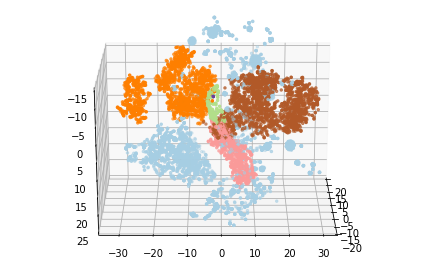

In [34]:
plot_animation(tsne_3d_df, 'labels', 'kmeans')

### Interpretation

Lets make an assumption that if the average value of a variable ordered by clusters differs significantly among each other, that variable is likely important in creating the clusters.

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
final_enc_df.head()

,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,...,participant5_action_liked,participant5_action_viewed,participant5_gender_female,participant5_gender_male,participant5_focus_engineering,participant5_focus_marketing,participant5_focus_other,participant5_focus_sales,cluster,rank
0,0.99973,1,0,1.00000,0,0,0,0,0,1,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.73677
1,0.99977,0,2,0.12336,0,0,0,1,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.78240
2,0.99977,0,3,0.12336,0,0,0,1,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3,0.82125
3,0.99949,0,0,0.00000,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.61522
4,0.99949,0,0,0.00000,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.61522


In [37]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(final_enc_df))
scaled_df.columns = final_enc_df.columns
scaled_df['kmeans'] = kmeans.labels_
scaled_df.head()

,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,...,participant5_action_viewed,participant5_gender_female,participant5_gender_male,participant5_focus_engineering,participant5_focus_marketing,participant5_focus_other,participant5_focus_sales,cluster,rank,kmeans
0,0.999789,0.015625,0.000000,1.00000,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.802200,0
1,0.999833,0.000000,0.013793,0.12336,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.858218,0
2,0.999833,0.000000,0.020690,0.12336,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.6,0.905912,3
3,0.999522,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.652978,0
4,0.999522,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.652978,0


In [38]:
df_mean = scaled_df.groupby('kmeans').mean().reset_index()
df_mean.head()

,kmeans,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,...,participant5_action_liked,participant5_action_viewed,participant5_gender_female,participant5_gender_male,participant5_focus_engineering,participant5_focus_marketing,participant5_focus_other,participant5_focus_sales,cluster,rank
0,0,0.714391,0.012263,0.002410,0.259676,0.000687,0.042115,0.004807,0.232090,0.008698,...,0.000229,0.999313,0.000000,1.000000,0.000000,0.495079,0.504692,0.000229,0.0,0.714468
1,1,0.986761,0.594289,0.083750,0.633318,0.011494,0.339080,0.057471,0.959770,0.310345,...,0.155172,0.000000,0.304598,0.695402,0.034483,0.781609,0.166667,0.017241,0.2,0.972402
2,2,0.791568,0.273438,0.019973,0.424428,0.004155,0.217452,0.030471,0.738227,0.131579,...,0.729917,0.000000,0.261773,0.738227,0.055402,0.757618,0.163435,0.023546,0.4,0.956796
3,3,0.856133,0.024309,0.024393,0.326426,0.011001,0.441069,0.034049,0.954950,0.014144,...,0.216344,0.491881,0.069670,0.930330,0.018858,0.616029,0.336302,0.028811,0.6,0.942150
4,4,0.000000,0.140625,0.862069,0.000000,0.000000,1.000000,0.750000,1.000000,0.750000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.250000,0.500000,0.250000,0.8,0.780547


In [39]:
results = pd.DataFrame(columns=['var', 'std'])

for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]

selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['kmeans']
selected_columns

['participant5_influence',
 'participant5_action_commented',
 'participant3_action_commented',
 'poster_focus_none',
 'participant4_action_commented',
 'participant5_action_viewed',
 'poster_influence',
 'kmeans']

In [40]:
# Plot data
tidy = scaled_df[selected_columns].melt(id_vars='kmeans')
tidy.head()

,kmeans,variable,value
0,0,participant5_influence,0.15391
1,0,participant5_influence,0.15391
2,3,participant5_influence,0.15391
3,0,participant5_influence,0.15391
4,0,participant5_influence,0.15391


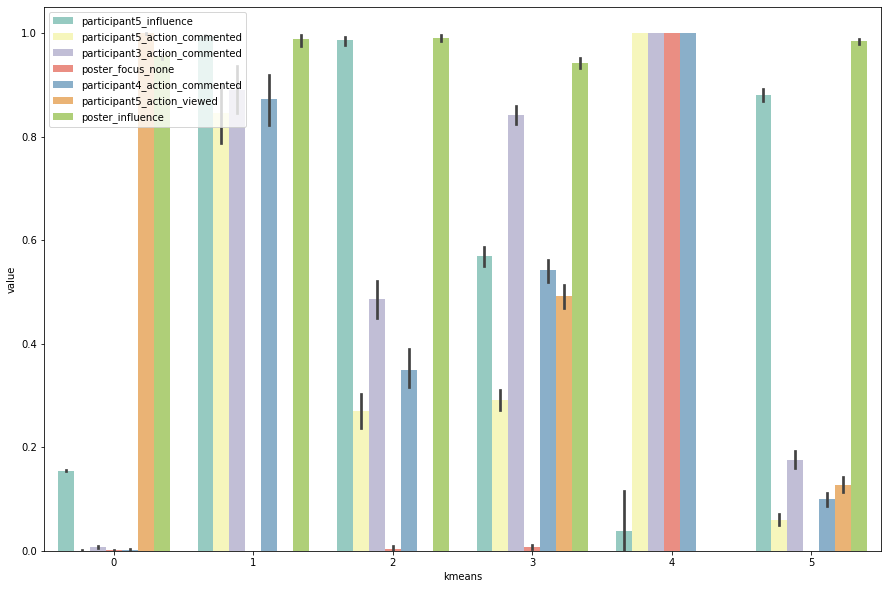

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmeans_results.jpg", dpi=300)